### Lab Assignment 4: Reading/writing gridded data in Python

**Objectives:**
   * We will get learn how to read/write gridded data using <code>rasterio</code> and <code>xarray</code>.
   * Learn how to reproject, resample and manipulate our gridded data.
   * Export our data as <code>GeoTIFF</code> or <code>NetCDF</code> format.
   * As always, visualize our data in QGIS

We will start by reading/writing some remote sensing data where each band is saved as separate <code>GeoTIFFs</code>. After that, we will read some climate reanalysis data saved as <code>NetCDF</code> format. We will reproject and resample both datasets to the same grid size and projection system.

In [5]:
# Import packages
import os
import glob

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import geopandas as gpd
import rasterio
import rioxarray
import xarray

### Read/write remote sensing data

In [3]:
# Define filepath
filepath = '/home/johnny/Documents/Teaching/490_Geospatial_Data_Science_Applications/course/labs/lab4/data/'

# Define list of Landsat bands
files = sorted(glob.glob(filepath + 'landsat/*.tif'))

In [4]:
files

['/home/johnny/Documents/Teaching/490_Geospatial_Data_Science_Applications/course/labs/lab4/data/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B1.tif',
 '/home/johnny/Documents/Teaching/490_Geospatial_Data_Science_Applications/course/labs/lab4/data/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B2.tif',
 '/home/johnny/Documents/Teaching/490_Geospatial_Data_Science_Applications/course/labs/lab4/data/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B3.tif',
 '/home/johnny/Documents/Teaching/490_Geospatial_Data_Science_Applications/course/labs/lab4/data/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B4.tif',
 '/home/johnny/Documents/Teaching/490_Geospatial_Data_Science_Applications/course/labs/lab4/data/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B5.tif',
 '/home/johnny/Documents/Teaching/490_Geospatial_Data_Science_Applications/course/labs/lab4/data/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B6.tif',
 '/home/johnny/Documents/Teaching/490_Geospatial_Dat

Next, open a single band from your Landsat scene. 

In [70]:
# Open a single band
src = rasterio.open(files[0])
band_1 = src.read(1) 

In [69]:
array.shape

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ..., 7350, 7394, 7301],
       [   0,    0,    0, ..., 7381, 7427, 7289],
       [   0,    0,    0, ..., 7435, 7322, 7382]], dtype=uint16)

Let's plot the data so we know what we're looking at.

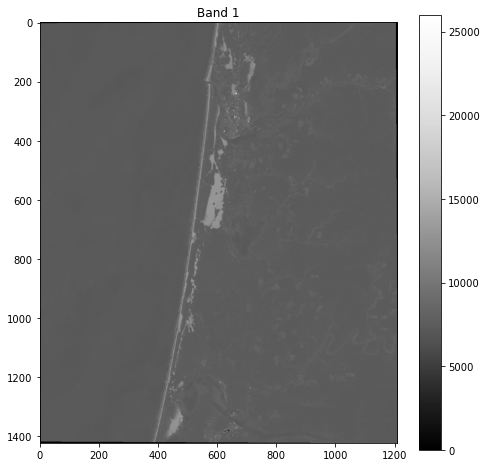

In [71]:
# Plot the data
fig, ax1 = plt.subplots(figsize=(8,8))
im = ax1.imshow(band_1, cmap="Greys_r")
ax1.set_title("Band 1")
plt.colorbar(im, orientation='vertical')
plt.show()

We often stack Landsat bands so we can conduct our analysis on all bands at the same time. The code below takes each band that you opened, and stacks it into a new single output array. 

In [78]:
# Open all bands in a loop
list_bands = []
for file in files:
    # Read band
    src = rasterio.open(file)
    band = src.read(1)
    
    # Append to list
    list_bands.append(band)

# Convert from list of arrays to n-dimensional array
all_bands = np.dstack(list_bands)

In [79]:
all_bands.shape

(1422, 1208, 7)

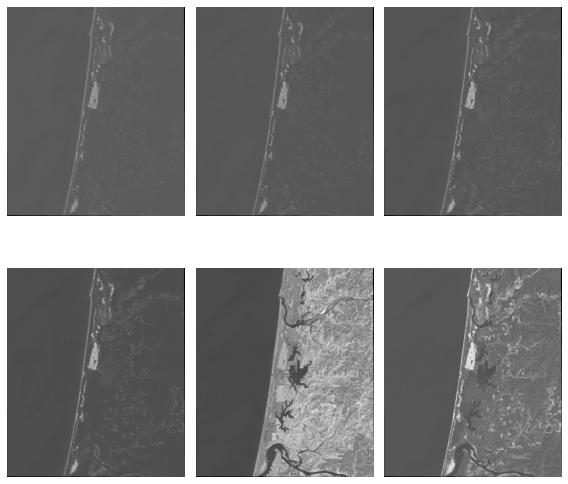

In [110]:
# Plot the first six bands
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(10,8))
ax1.imshow(all_bands[:,:,0], cmap="Greys_r")
ax2.imshow(all_bands[:,:,1], cmap="Greys_r")
ax3.imshow(all_bands[:,:,2], cmap="Greys_r")
ax4.imshow(all_bands[:,:,3], cmap="Greys_r")
ax5.imshow(all_bands[:,:,4], cmap="Greys_r")
ax6.imshow(all_bands[:,:,5], cmap="Greys_r")
ax7.imshow(all_bands[:,:,6], cmap="Greys_r")
for ax in (ax1, ax2, ax3, ax4, ax5, ax6):
    ax.set_axis_off()
plt.tight_layout()

Write stacked array to GeoTIFF

In [103]:
# Write an array as a raster band to a new 16-bit file. For the new file's profile, 
# we start with the profile of the source
profile = src.profile

# And then change the band count to 7, set the dtype to uint16, and specify LZW compression.
profile.update(
    dtype=rasterio.uint16,
    count=7,
    compress='lzw')

In [107]:
with rasterio.open(filepath + 'stacked.tif', 'w', **profile) as dst:
    # Write array
    dst.write(np.rollaxis(all_bands, axis=2)) # Note that array needs to be in bands, rows, cols order (z, y, x)

### Question 1 (10 points): 
Add this new GeoTIFF layer to your QGIS workspace and display it as a **color infrared composite**. Remember that the bands correspond to following wavelengths: https://www.usgs.gov/media/images/landsat-8-band-designations. Copy and paste your map to your answers document.

### Question 2 (20 points): 
Now compute a new array in Python called **NDVI** which is defined as (Band 5 - Band 4) / (Band 5 + Band 4). Export this new layer as a GeoTIFF, add it to your QGIS workspace and copy and paste your map to your answers document. 

### Read/write climate reanalysis data

We usually use the <code>netCDF4</code> or <code>xarray</code> packages for this task.

In [22]:
# Read data
xds = xarray.open_dataset(filepath + 'era/usa_t2m_cloud_2020.nc', decode_coords='all')

In [23]:
xds

<xarray.Dataset>
Dimensions:    (longitude: 241, latitude: 105, time: 1464)
Coordinates:
  * longitude  (longitude) float32 -126.0 -125.8 -125.5 ... -66.5 -66.25 -66.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 24.5 24.25 24.0
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-12-31T18:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-12-06 01:23:20 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

This looks a bit overwelming but it nice way to store gridded data. Below is a schematic of what an xarray data structure represents.

<div>
<img src="images/xarray_data_structures.png" width="600"/>
</div>

In [36]:
# Print the time period of the data
print('The data ranges from %s to %s' %(xds['t2m']['time'].values.min(), xds['t2m']['time'].values.max()))

The data ranges from 2020-01-01T00:00:00.000000000 to 2020-12-31T18:00:00.000000000


So we know the data spans one year but there are 1464 dimensions in the time variable. This means that the reanalysis data must have a temporal resolution of 6 hours. So before we continue we will resample to daily temporal resolution.

In [37]:
xds_daily = xds.resample(time='1D').mean()
xds_daily

<xarray.Dataset>
Dimensions:    (time: 366, longitude: 241, latitude: 105)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * longitude  (longitude) float32 -126.0 -125.8 -125.5 ... -66.5 -66.25 -66.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 24.5 24.25 24.0
Data variables:
    t2m        (time, latitude, longitude) float32 277.9 277.8 ... 296.5 296.5
    tcc        (time, latitude, longitude) float32 0.9636 0.9137 ... 0.3232

Now each layer in the dataset corresponds to a single day. Let's plot the air temperature and cloud cover for the day which the Landsat image was acquired (August 14, 2020).

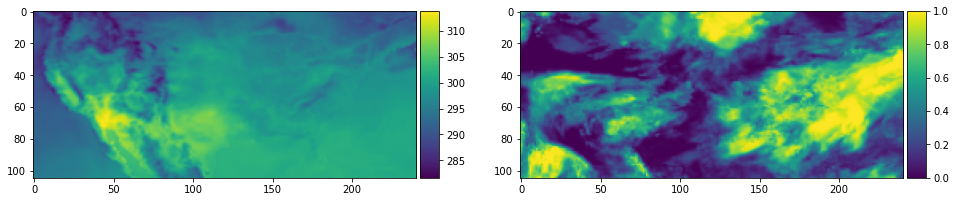

In [47]:
# Plot data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
im1 = ax1.imshow(xds_daily['t2m'][226,:,:])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax2.imshow(xds_daily['tcc'][226,:,:])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

So we know that is was relatively cold, cloud-free day in Florence, just like we see in the Landsat image. But how anomalous were these conditions? We can investigate by finding the nearest climate reanalysis grid cell to Florence, OR.

In [48]:
lat, lon = 43.974659, -124.103142

In [50]:
# First, find the index of the grid point nearest a specific lat/lon.   
abslat = np.abs(xds_daily['latitude'] - lat)
abslon = np.abs(xds_daily['longitude'] - lon)
c = np.maximum(abslon, abslat)

([xloc], [yloc]) = np.where(c == np.min(c))

In [70]:
print('Cloud cover in Florence on Aug 14, 2020 = %.2f %%' % (xds_daily['tcc'][226, yloc, xloc].values * 100))

Cloud cover in Florence on Aug 14, 2020 = 0.02 %


In [76]:
fahrenheit = (xds_daily['t2m'][226, yloc, xloc].values - 273.15) * 9/5 + 32
print('Air temperature in Florence on Aug 14, 2020 = %.2f F' % (fahrenheit))

Air temperature in Florence on Aug 14, 2020 = 62.18 F


These values look about right. Now we can plot the time series.

Text(0, 0.5, 'Cloud cover (%)')

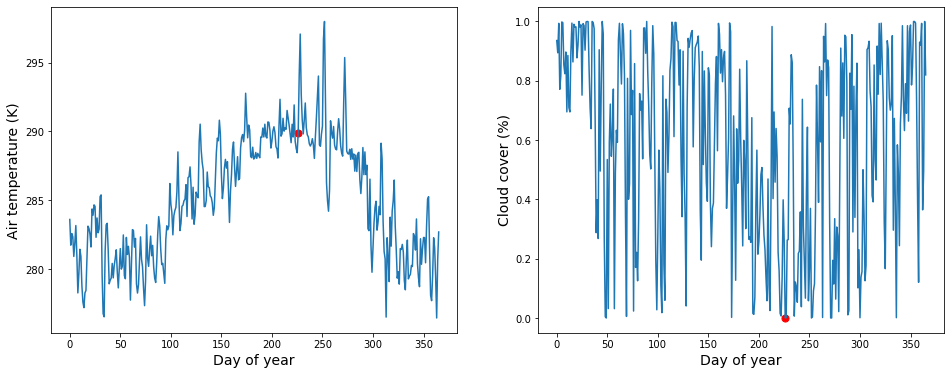

In [111]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.plot(xds_daily['t2m'][:, yloc, xloc])
ax1.scatter(226, xds_daily['t2m'][226, yloc, xloc], s=50, color='r')
ax1.set_xlabel('Day of year', fontsize=14)
ax1.set_ylabel('Air temperature (K)', fontsize=14)

ax2.plot(xds_daily['tcc'][:, yloc, xloc])
ax2.scatter(226, xds_daily['tcc'][226, yloc, xloc], s=50, color='r')
ax2.set_xlabel('Day of year', fontsize=14)
ax2.set_ylabel('Cloud cover (%)', fontsize=14)

It was a pretty nice warm day in Florence on Aug 14, 2020 relative to mean annual conditions. But what is the actual mean?

In [107]:
mean_temp = (xds_daily['t2m'][:, yloc, xloc].mean() - 273.15) * 9/5 + 32
print('Mean air temp. in Florence in 2020 = %.2f F' % (mean_temp))

Mean air temp. in Florence in 2020 = 53.52 F


In [92]:
mean_cloud = xds_daily['tcc'][:, yloc, xloc].mean()
print('Mean cloud cover in Florence in 2020 = %.2f %%' % (mean_cloud * 100))

Mean cloud cover in Florence in 2020 = 58.77 %


Finally, let's calculate how many days had less than 20% cloud cover in Florence

In [117]:
days = np.sum(xds_daily['tcc'][:, yloc, xloc] < 0.2).values
print('There were %.0f days with less than 20%% cloud cover in 2020' % days)

There were 62 days with less than 20% cloud cover in 2020


### Question 2 (25 points): 
Using the climate reanalysis dataset, find the following grid cells and provide a rough location of where they are located. You can use the following link to convert your lat/lons to an address: https://www.latlong.net/Show-Latitude-Longitude.html
* a) Warmest place 
* b) Coldest place
* c) Most cloudy place
* d) Least cloudy place
* e) Place with highest range in temperature

In [104]:
# HINT use argmax()
max_value = np.mean(xds_daily['t2m'], axis=0).argmax()
index = np.unravel_index(max_value, np.mean(xds_daily['t2m'], axis=0).shape)

(104, 163)